In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import locale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
from statsmodels.tsa.api import VAR


locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')
df = pd.read_csv('../data/df_analise.csv').set_index('Data')
df.index = pd.to_datetime(df.index, format='%b/%Y')
df = df.asfreq(pd.infer_freq(df.index))

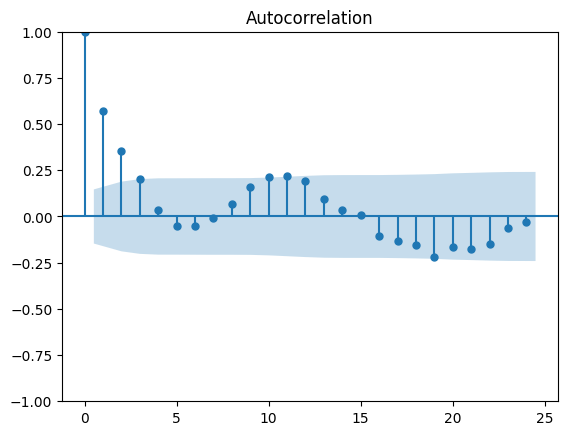

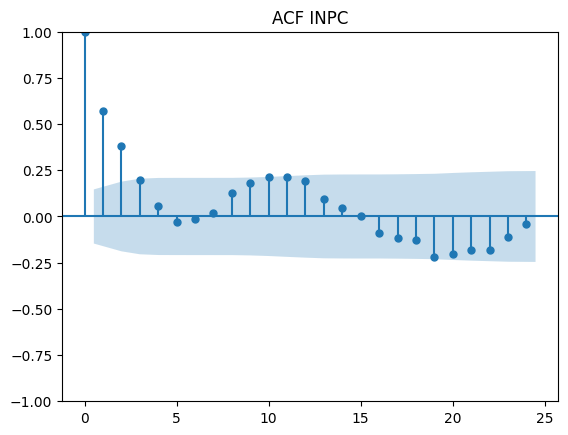

In [30]:
plot_acf(x=df['IPCA'], lags=24)
plot_acf(x=df['INPC'], lags=24)
plt.show()

In [20]:
result_adfuller = adfuller(df['IPCA'], autolag='AIC')
print('Stationary: ' + str(result_adfuller[1] < 0.05))

Stationary: True


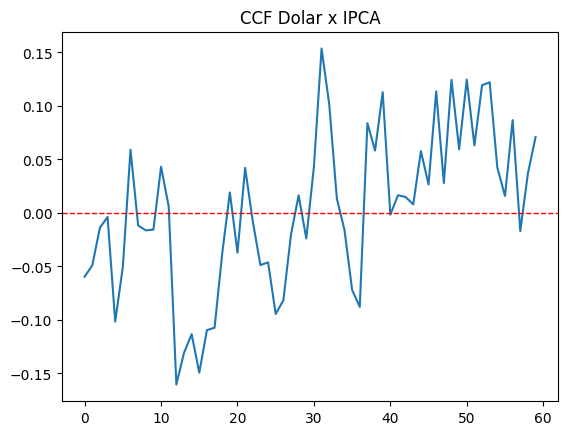

In [21]:
result_ccf = ccf(df['Dolar'], df['IPCA'], adjusted=True)[:60]
plt.plot(result_ccf, label='ccf')
plt.title('CCF Dolar x IPCA')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

In [22]:
model = VAR(df[['Dolar', 'IPCA']])
lag_order = model.select_order(maxlags=24)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,1.029,1.068,2.799,1.045
1,0.6964*,0.8142*,2.006*,0.7442*
2,0.7419,0.9382,2.100,0.8216
3,0.7896,1.064,2.203,0.9012
4,0.7224,1.076,2.060,0.8659
5,0.7715,1.203,2.164,0.9469
6,0.7690,1.279,2.159,0.9763
7,0.8040,1.393,2.237,1.043
8,0.8027,1.470,2.236,1.074
9,0.8352,1.581,2.311,1.138


In [23]:
result_var = model.fit(maxlags=1)
print(result_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 29, abr, 2025
Time:                     16:05:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.721831
Nobs:                     178.000    HQIC:                  0.658073
Log likelihood:          -553.840    FPE:                    1.84889
AIC:                     0.614580    Det(Omega_mle):         1.78811
--------------------------------------------------------------------
Results for equation Dolar
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.124742         0.566241            1.986           0.047
L1.Dolar        -0.039107         0.075421           -0.519           0.604
L1.IPCA         -0.638154         0.940571           -0.678           0.497

Res

In [24]:
cause = result_var.test_causality('IPCA', 'Dolar', kind='f')
cause.summary()

Test statistic,Critical value,p-value,df
0.4117,3.868,0.522,"(1, 350)"


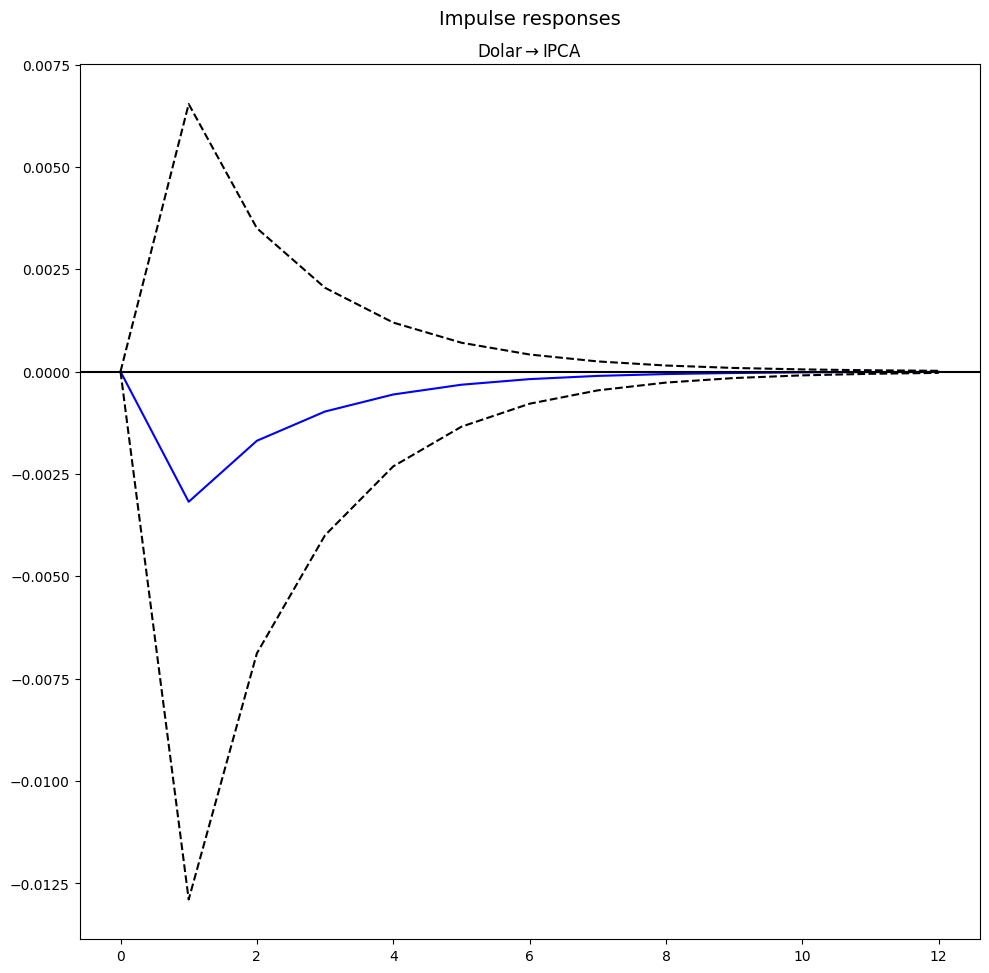

In [25]:
irf = result_var.irf(12)
irf.plot(impulse='Dolar', response='IPCA')
plt.show()

In [26]:
dolar_index = 0
x_index = 1

# Respostas de x a choques no Dólar
response_x_to_dolar = irf.orth_irfs [:, dolar_index, x_index]

for month, value in enumerate(response_x_to_dolar):
    print(f"Mês {month}: {value:.5f}")

Mês 0: 0.00000
Mês 1: -0.18912
Mês 2: -0.10050
Mês 3: -0.05802
Mês 4: -0.03328
Mês 5: -0.01910
Mês 6: -0.01096
Mês 7: -0.00629
Mês 8: -0.00361
Mês 9: -0.00207
Mês 10: -0.00119
Mês 11: -0.00068
Mês 12: -0.00039


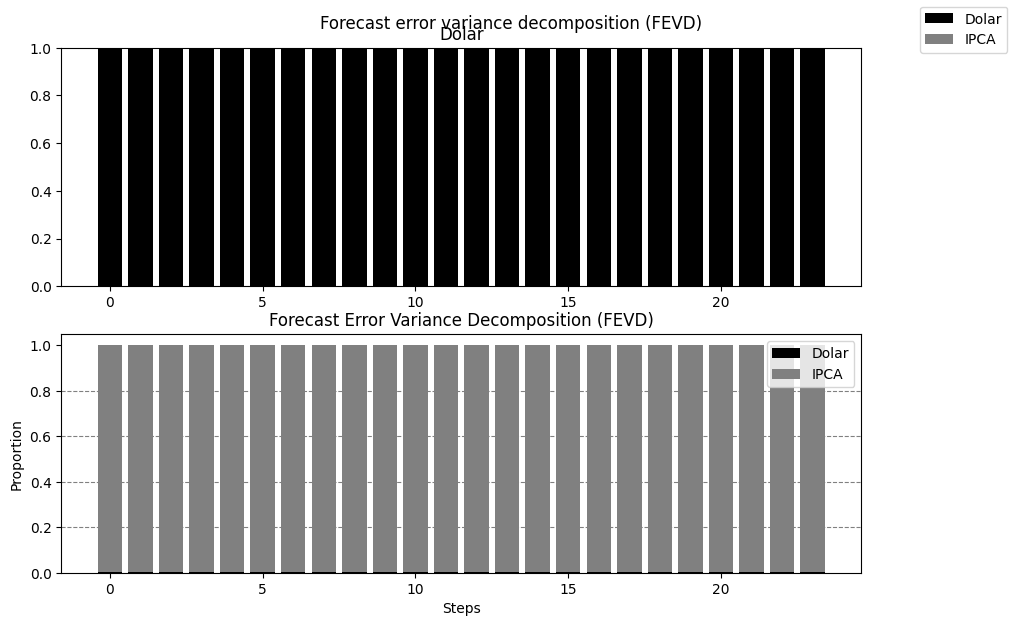

In [27]:
fevd = result_var.fevd(24)

# Plot the FEVD
fevd.plot(figsize=(10, 6))
plt.title("Forecast Error Variance Decomposition (FEVD)")
plt.xlabel("Steps")
plt.ylabel("Proportion")
plt.legend(loc='best')

for level in [0.2, 0.4, 0.6, 0.8]:
    plt.axhline(level, color='gray', linestyle='--', linewidth=0.8)

plt.show()

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

def diagnostico_residuos(residuals, lags=12):
    for col in residuals.columns:
        print(f'\n--- Variável: {col} ---')

        # Autocorrelação
        lb_test = acorr_ljungbox(residuals[col], lags=[lags], return_df=True)
        print(f'Ljung-Box (p={lags}): {lb_test["lb_pvalue"].values[0]:.4f} → {"OK" if lb_test["lb_pvalue"].values[0] > 0.05 else "Problema"}')

        # Normalidade
        jb_stat, jb_pval, _, _ = jarque_bera(residuals[col])
        print(f'Jarque-Bera: p = {jb_pval:.4f} → {"OK" if jb_pval > 0.05 else "Não normal"}')

        # Heterocedasticidade
        arch_test = het_arch(residuals[col])
        print(f'ARCH test: p = {arch_test[1]:.4f} → {"OK" if arch_test[1] > 0.05 else "Heterocedástico"}')

diagnostico_residuos(result_var.resid)


--- Variável: Dolar ---
Ljung-Box (p=12): 0.8813 → OK
Jarque-Bera: p = 0.0009 → Não normal
ARCH test: p = 0.5256 → OK

--- Variável: IPCA ---
Ljung-Box (p=12): 0.5568 → OK
Jarque-Bera: p = 0.0000 → Não normal
ARCH test: p = 0.3724 → OK
